In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
# svm
from sklearn.svm import SVC
# image descriptors
from skimage.feature import hog, local_binary_pattern, daisy, ORB, BRIEF, CENSURE
from skimage import io, color, exposure
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import data
import skimage.feature
from sklearn.ensemble import RandomForestClassifier
# mlp
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve, validation_curve, StratifiedKFold, KFold
import io
from PIL import Image, ImageOps
import cv2
from sklearn.preprocessing import MinMaxScaler
from skimage.util import view_as_blocks, img_as_ubyte
from multiprocessing import Pool

# Loading stuff


In [176]:
dataset_dir = "D:\\Computer Science\\TCC Ciência e Tecnologia\\src\\others\\DogFaceNet\\dogfacenet_dataset"

# images_dir = "C:\\Users\\T-Gamer\\Desktop\\MyFuture\\oitavo semestre\\TCC\\TCC psao\\DogFaceNet_Dataset_224_1\\after_4_bis"

images_dir = os.path.join(dataset_dir, "DogFaceNet_Dataset_224_1\\after_4_bis")

img_and_label_list = []

# every dir name is a label
for label in os.listdir(images_dir):
    label_dir = os.path.join(images_dir, label)
    for img in os.listdir(label_dir):
        img_and_label_list.append((os.path.join(label_dir, img), label))


df = pd.DataFrame(img_and_label_list, columns=["path", "label"])
pd.set_option('display.max_colwidth', None)
# display(df)
# df.to_csv("dogfacenet_dataset.csv", index=False)

# Spliting the dataset into train and test


In [ ]:
#spliting dataset
# a, min_df = train_test_split(df, test_size=0.5, stratify=df["label"])



In [ ]:
# Removing classes with less than 4 samples
df = df.groupby("label").filter(lambda x: len(x) > 3)

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"])

In [ ]:
display(train_df)

In [ ]:
label_counts = train_df['label'].value_counts()
print(label_counts)

In [ ]:
label_counts = test_df['label'].value_counts()
print(label_counts)

# Image preprocessing functions


In [ ]:
def resize_img(img):
    return cv2.resize(img, (128, 128))

def print_data_shape(data):
    return data

def rgb2gray_img(img):
    # 0-255 integer array
    return (rgb2gray(img)*255).astype(np.uint8)

def extract_patches(img):
    img = np.atleast_2d(img)
    return extract_patches_2d(img, (8, 8))

def safe_imread(path):
    img = Image.open(path)
    if img is None:
        raise ValueError(f"Image couldn't be read from the path: {path}")
    return np.array(img)

def flatten(data):
    return data.flatten()

def hist_blocks(img, b_shape):
    return np.array([np.histogram(block.flatten(), bins=10, range=(0, 1))[0] for block in view_as_blocks(img, block_shape=b_shape).reshape(-1, *b_shape)])


In [175]:
def hog_descriptor(img):

    return hog(img, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1)).flatten()

def lbp_descriptor(img):

    shape = (8, 8)
    return hist_blocks(
        local_binary_pattern(np.atleast_2d(img), P=8, R=1, method='uniform'),
        shape
    ).flatten()

def daisy_descriptor(img):
    return daisy(img).flatten()

def orb_descriptor(img):
    orb = ORB(n_keypoints=200)
    orb.detect_and_extract(img)
    return orb.descriptors.flatten()

def brief_descriptor(img):
    brief = BRIEF()
    brief.extract(img, )
    return brief.descriptors.flatten()

def censure_descriptor(img):
    censure = CENSURE()
    censure.detect(img)
    return censure.descriptors.flatten()

def color_histogram(img):
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # print("hist shape", hist.shape)
    return hist.flatten()


def block_mean(img):
    # Define the block size
    block_shape = (8, 8, 3)

    # Use view_as_blocks to divide the image into blocks
    blocks = view_as_blocks(img, block_shape)

    # Calculate the mean of each block and replicate it to fill the block
    mean_blocks = np.repeat(np.repeat(np.mean(blocks, axis=(1, 2, 3)), 8, axis=1), 8, axis=2)

    # Reshape the result to match the original image shape
    output = mean_blocks.reshape(img.shape)

    return output

def zigzag_fun(data: np.ndarray):
    return np.concatenate([np.diagonal(data[::-1, :], offset=i)[::(2*(i % 2)-1)] for i in range(1-data.shape[0], data.shape[0])])

dct_fun = np.vectorize(cv2.dct, signature='(m,n)->(m,n)')
zigzag_fun = np.vectorize(zigzag_fun, signature='(m,n)->(mxn)')

def color_layout_descriptor(img: np.ndarray):
    """" 
    Computes the Color Layout Descriptor (CLD) of an image.

    Stages
    -------
    Stage 1: Divide the image into 8x8 blocks.\n
    Stage 2: Calculate the average color for each block.\n
    Stage 3: Convert to YCbCr color space.\n
    Stage 4: Apply the Discrete Cosine Transform (DCT), to obtain 
    3 [8x8] matrix of 64 coefficients (DCTY, DCTCb, DCTCr).\n
    Stage 5: Perform zigzag scanning to obtain (DY, DCb, DCr)

    Parameters
    ----------
    img: ndarray
        The image to compute the descriptor.

    Returns
    -------
    ndarray
        The CLD of the image.
    """ 

    # Stage 1
    blocks = view_as_blocks(img, block_shape=(8, 8, 3)).reshape(-1, 8, 8, 3)

    #Stage 2
    icon_avg_img = np.mean(blocks, axis=(1, 2)).reshape(img.shape[0]//8, img.shape[1]//8, 3).astype(np.float32)

    avg_img = np.resize(icon_avg_img, img.shape)

    # Stage 3
    ycbcr = cv2.cvtColor(avg_img, cv2.COLOR_RGB2YCrCb)

    # Stage 4
    dct = dct_fun(cv2.split(ycbcr))

    return dct.flatten()

    # return dct.flatten()

    # Stage 5 - But why would I sort the dct?

    # zig = zigzag_fun(dct)
    
    # return zig.flatten()



# Testing zigzag function


In [ ]:
test = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

print(test)

print(zigzag_fun(test))

In [ ]:
def get_feat_list(d):

    descriptors = (
        hog_descriptor,
        lbp_descriptor,
        eigenfaces_descriptor,
        # orb_descriptor,
    )

    return np.concatenate([desc(d) for desc in descriptors])

def gray_feat_extraction(x):

    return get_feat_list(rgb2gray_img(x))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, name=None):
        self.transformer = transformer
        self.name = name

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([self.transformer(data) for data in X])
    

class ConcatTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformers, keep_original=True):
        self.transformers = transformers
        self.keep_original = keep_original

    def concat(self, x, transformers, keep_original=True):
     
        if keep_original:
            return np.concatenate((
                x.flatten(),
                np.concatenate([np.squeeze(transformer(x.copy())).flatten() for transformer in transformers])
            ))
        return np.concatenate([np.squeeze((transformer(x.copy())).flatten()) for transformer in transformers])

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([(self.concat(data, self.transformers, self.keep_original)) for data in X])

In [ ]:
load_pipe = make_pipeline(
    DataTransformer(safe_imread),
    DataTransformer(resize_img),
)
X_train = load_pipe.transform(train_df["path"])
X_test = load_pipe.transform(test_df["path"])


# Eigenfaces


(6284, 16384)
Extracting the top 5969.00 eigenfaces...


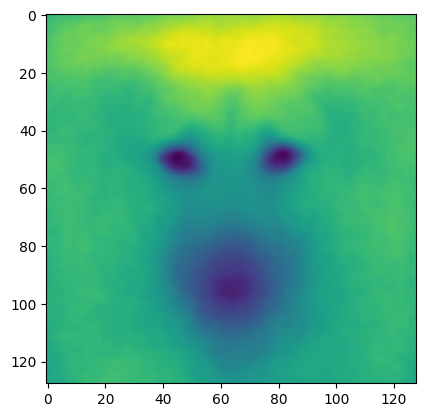

In [189]:
faces = np.array([face.flatten() for face in rgb2gray_img(X_train)])

avg_face = np.mean(faces, axis=0)

n_samples, h, w, _ = X_train.shape

n_components = int(0.95 * n_samples)

print(faces.shape)

print("Extracting the top %.2f eigenfaces..." % n_components)
pca = PCA(n_components=n_components, whiten=True).fit(faces)

# The principal components measure deviations about this mean along orthogonal axes.
eigenfaces = pca.components_.reshape((n_components, h, w))




In [201]:
# weights for all images
weights = pca.transform(faces)

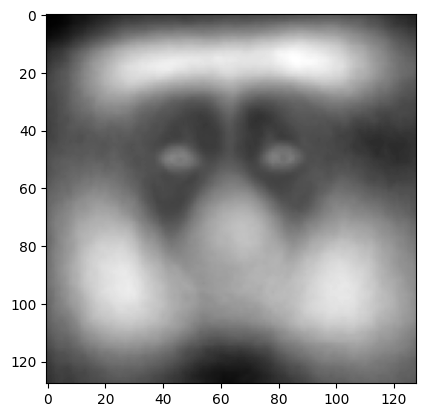

In [200]:
plt.imshow(eigenfaces[10], cmap='gray')

In [179]:
faces.flatten().shape

(102957056,)

# KNN


In [ ]:

main_pipe = make_pipeline(
    
     ConcatTransformer(
         transformers= (
            color_layout_descriptor,
            gray_feat_extraction, 
            color_histogram,
         ),
         keep_original=False,
     ),
    DataTransformer(flatten),
    MinMaxScaler(),
    

    # PCA(n_components=0.95),

    KNeighborsClassifier(n_neighbors=1, metric='l1'),


)

main_pipe.fit(X_train, train_df["label"])
y_pred = main_pipe.predict(X_test)
print(classification_report(test_df["label"], y_pred))




In [ ]:
print(y_pred == test_df["label"])

In [ ]:
full_pipe = make_pipeline(
    load_pipe,
    
    KNeighborsClassifier(n_neighbors=7),
    verbose = True
)